Detecting the direction of a neutrino from cosmos is important to understand the exceptional phenomena in the universe. They are detected as they are deflected on the sensors placed in the Antarctic region through noticeable reaction with matter to produce balls of light on the detectors. The calculation of Azimuth and Zenith angle would help figure out the orientation of earth with the source's plane and the exact position of the source.

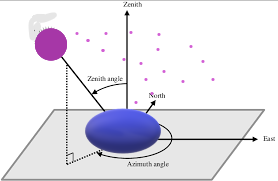

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import polars as pl
import math

In [3]:
sensordf=pd.read_csv('/kaggle/input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv')

In [4]:
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import HuberRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

Huber Regressor is employed to minimize the effect of falsely detected pulses,to obtain the direction of the neutrinos to be deduced from each batch of events provided. The path of neutron traversal is traced for each event through the calculated azimuth and zenith angles.

In [5]:
def conversion(az,zen):
    l=len(az)
    x=[]
    y=[]
    z=[]
    i=0
    for i in np.arange(l):
        z.append(math.cos(zen[i]))
        x.append(math.cos(az[i])*math.sin(zen[i]))
        y.append(math.sin(az[i])*math.sin(zen[i]))
    return x,y,z

In [6]:
zenreg=np.array([2.18227660e-05, 3.48103408e-05, 1.24068101e-11])
azreg=np.array([-6.38719228e-07, 1.24188883e-04, -3.63128495e-13])
sa=np.array([8.48240613e-06, 6.19646559e-05, 7.15244887e-12])
sz=np.array([7.26575993e-06, 1.63302382e-05, 6.12656075e-12])

The linear regression coefficients are obtained to be used to predict the direction of each event to track the points of interaction of neutrinos to further obtain the Azimuth and Zenith angles of the corresponding occurrence. Reference to the notebook attached would cover the process used to obtain the coefficients.

https://www.kaggle.com/sumamallapragada/neutrino-observation

In [7]:
ac=(sa+azreg)/2

In [8]:
zc=(sz+zenreg)/2

In [9]:
reg=LinearRegression()
regz=LinearRegression()
reg.coef_=ac
regz.coef_=zc
reg.intercept_=0.02
regz.intercept_=0.02

In [10]:
def gethuber(btdf):
    dn=np.array(btdf['vel_dist'])
    dd=dn.reshape(-1,1)
    huberpred = HuberRegressor().fit(dd,btdf['auxiliary'])
    hl=list(huberpred.predict(dd))
    return hl

The velocity of the neutrinos while striking the sensors would help predict the distance they covered at the instance recorded and the path they would take while distinguishing between noisy intervention using a huber fit between distance and auxiliary.

In [11]:
def fetchxyz(btdf):
    hl=gethuber(btdf)
    ntdf=btdf
    ntdf['predict_clarity']=hl
    pra=reg.predict(btdf[['vel_dist','sensor_id','predict_clarity']].values)
    prz=regz.predict(btdf[['vel_dist','sensor_id','predict_clarity']].values)
    ntdf['x'],ntdf['y'],ntdf['z']=conversion(pra,prz)
    return ntdf

The direction of each particle is obtained as a fit dependent on distance travelled by the neutrino, clarity of the detected signal going in the visualized direction,sensor id of the sensor struck. The path is tracked as x,y,z coordinates are obtained for the most obvious route detected through the azimuth,zenith angles obtained for each instance of the particular event from the regression fit.

In [12]:
def predangle(df):
    p1c=np.cov(df['z'],df['x'])
    a1=p1c[0][1]/p1c[0][0]
    p2c=np.cov(df['z'],df['y'])
    a2=p2c[0][1]/p2c[0][0]
    d=np.sqrt(1+a1**2+a2**2)
    azimuth=np.arctan2(a2,a1)
    if azimuth<0:
        azimuth=2*np.pi+azimuth
    zenith=np.arccos(1/d)
    return azimuth,zenith

The azimuth and zenith angles for each event are deduced from the x,y,z orientation of the neutrinos obtained.Computation is considered through the relations given by,

x = cos(azimuth) * sin(zenith)

y = sin(azimuth) * sin(zenith)

z = cos(zenith)

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
import glob

In [15]:
tm=pl.read_parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/test_meta.parquet')
tem=tm.to_pandas()
ls=len(tem)

In [16]:
def updateangle(testmeta):
    anglaz=[]
    anglze=[]
    t=glob.glob(os.path.join('/kaggle/input/icecube-neutrinos-in-deep-ice', "test", "*.parquet"))
    t.sort()
    count=0
    for b in t:
        testdf=pl.read_parquet(b)
        tes=testdf.to_pandas()
        l=tes['time'][0]
        tes["vel_dist"]=(tes["time"]-l)*0.158 #compute the distance travelled
        for i in range(count,ls):
            btdf=tes.iloc[testmeta.iloc[i].first_pulse_index.astype(int):testmeta.iloc[i].last_pulse_index.astype(int)+1].copy()
            direct=fetchxyz(btdf) #obtain the orientation of the neutrinos for each event.
            pa,pz=predangle(direct)#obtain the azimuth and zenith
            anglaz.append(pa)
            anglze.append(pz)
            count+=1
        del testdf
    return anglaz,anglze

In [17]:
angle_a,angle_z=updateangle(tem)

In [18]:
tem['azimuth']=angle_a
tem['zenith']=angle_z

In [19]:
subp=tem[['event_id', 'azimuth', 'zenith']]

In [20]:
subp

,event_id,azimuth,zenith
0,2092,3.679622,1.475926
1,7344,3.731160,1.480751
2,9482,3.794852,1.472428


In [21]:
subp.to_csv("submission.csv",index=False)